In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import ImageGrid

from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Input, BatchNormalization, Activation, ReLU, MaxPool2D, Concatenate
from tensorflow.keras.models import Model

2024-02-18 19:25:59.104892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 19:25:59.104936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 19:25:59.106063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 19:25:59.112384: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 19:25:59.849383: W tensorflow/comp

In [2]:
from image_processing import prep_dataset, thresholding

In [3]:
print("TensorFlow version:", tf.__version__)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("Active GPU devices:")
    for gpu in gpus:
        print("  -", gpu.name)
else:
    print("No GPU devices found.")

TensorFlow version: 2.15.0
Active GPU devices:
  - /physical_device:GPU:0
  - /physical_device:GPU:1


## Load Data

In [4]:
img_paths, mask_paths = prep_dataset.load_img_paths("../data/inpainting/AugmentedData")

In [5]:
imgs, masks = prep_dataset.read_paths_and_threshold(img_paths, mask_paths, 2, 2)

Function 'read_paths_and_threshold' executed in 3.3268s


In [6]:
train_x, val_x, train_y, val_y = prep_dataset.setup_datasets(imgs, masks, norm_type='01')
val_x, test_x, val_y, test_y = train_test_split(val_x, val_y, test_size=0.5, random_state=0)
train_x.shape, val_x.shape, test_x.shape

Function 'setup_datasets' executed in 0.3482s


((800, 256, 256, 1), (100, 256, 256, 1), (100, 256, 256, 1))

In [7]:
np.min(train_x)

0.0

In [8]:
np.max(train_x)

0.5019607843137255

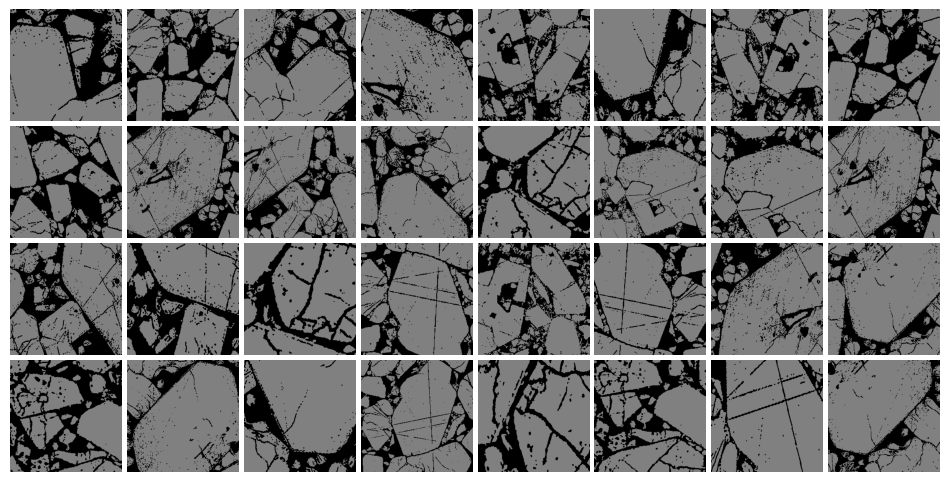

In [9]:
sample_images = train_x[:32]

fig = plt.figure(figsize=(12., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  
                 axes_pad=0.05,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')  

plt.show()

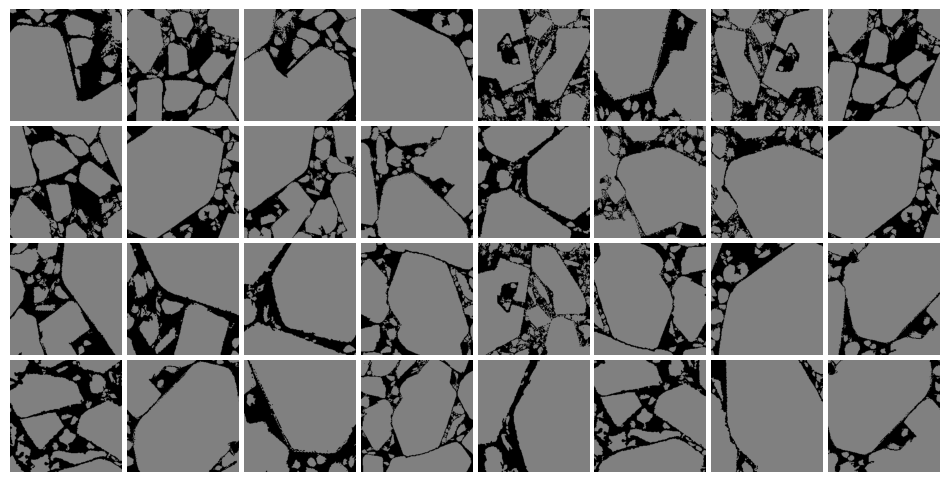

In [10]:
sample_masks = train_y[:32]

fig = plt.figure(figsize=(12., 8.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),  # creates a 4x8 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_masks):
    ax.imshow(image, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')  

plt.show()

# Model

In [11]:
class inpaintingModel:
    def prepare_model(self, input_size=(256, 256, 1)):  
        inputs = keras.layers.Input(input_size)

        conv1, pool1 = self.__ConvBlock(32, (3, 3), (2, 2), 'relu', 'same', inputs) 

        conv2, pool2 = self.__ConvBlock(64, (3, 3), (2, 2), 'relu', 'same', pool1)
        conv3, pool3 = self.__ConvBlock(128, (3, 3), (2, 2), 'relu', 'same', pool2)
        conv4, pool4 = self.__ConvBlock(256, (3, 3), (2, 2), 'relu', 'same', pool3)

        conv5, up6 = self.__UpConvBlock(512, 256, (3, 3), (2, 2), (2, 2), 'relu', 'same', pool4, conv4)
        conv6, up7 = self.__UpConvBlock(256, 128, (3, 3), (2, 2), (2, 2), 'relu', 'same', up6, conv3)
        conv7, up8 = self.__UpConvBlock(128, 64, (3, 3), (2, 2), (2, 2), 'relu', 'same', up7, conv2)
        conv8, up9 = self.__UpConvBlock(64, 32, (3, 3), (2, 2), (2, 2), 'relu', 'same', up8, conv1)

        conv9 = self.__ConvBlock(32, (3, 3), (2, 2), 'relu', 'same', up9, False)

        outputs = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv9)  

        return keras.models.Model(inputs=[inputs], outputs=[outputs])
    def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        conv = keras.layers.Dropout(0.2)(conv)
        if pool_layer:
            pool = keras.layers.MaxPooling2D(pool_size)(conv)
            return conv, pool
        else:
            return conv

    def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
        conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
        conv = keras.layers.Dropout(0.2)(conv)
        up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
        up = keras.layers.concatenate([up, shared_layer], axis=3)

        return conv, up

In [12]:
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

In [13]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-5,
#     decay_steps=100,
#     decay_rate=0.9)
#optimizer = keras.optimizers.Adam(learning_rate=1e-5)

In [14]:
keras.backend.clear_session()
model = inpaintingModel().prepare_model()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[dice_coef])

2024-02-18 19:26:08.000621: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21425 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-02-18 19:26:08.001209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22457 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [15]:
# model.summary()

In [16]:
history = model.fit( train_x, train_y, validation_data=[val_x, val_y], epochs=100 )

Epoch 1/100


2024-02-18 19:26:10.962642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-18 19:26:11.318080: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-02-18 19:26:11.403703: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-18 19:26:11.755048: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-18 19:26:14.726585: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f498920d220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-18 19:26:14.726613: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, C

25/25 [==============================] - 26s 242ms/step - loss: 0.0327 - dice_coef: 0.4340 - val_loss: 0.0101 - val_dice_coef: 0.4706
Epoch 2/100
25/25 [==============================] - 4s 167ms/step - loss: 0.0102 - dice_coef: 0.4790 - val_loss: 0.0078 - val_dice_coef: 0.4786
Epoch 3/100
25/25 [==============================] - 4s 167ms/step - loss: 0.0089 - dice_coef: 0.4799 - val_loss: 0.0073 - val_dice_coef: 0.4831
Epoch 4/100
25/25 [==============================] - 4s 166ms/step - loss: 0.0085 - dice_coef: 0.4808 - val_loss: 0.0067 - val_dice_coef: 0.4842
Epoch 5/100
25/25 [==============================] - 4s 171ms/step - loss: 0.0079 - dice_coef: 0.4816 - val_loss: 0.0063 - val_dice_coef: 0.4846
Epoch 6/100
25/25 [==============================] - 4s 170ms/step - loss: 0.0075 - dice_coef: 0.4838 - val_loss: 0.0062 - val_dice_coef: 0.4838
Epoch 7/100
25/25 [==============================] - 4s 171ms/step - loss: 0.0072 - dice_coef: 0.4837 - val_loss: 0.0054 - val_dice_coef: 0.4

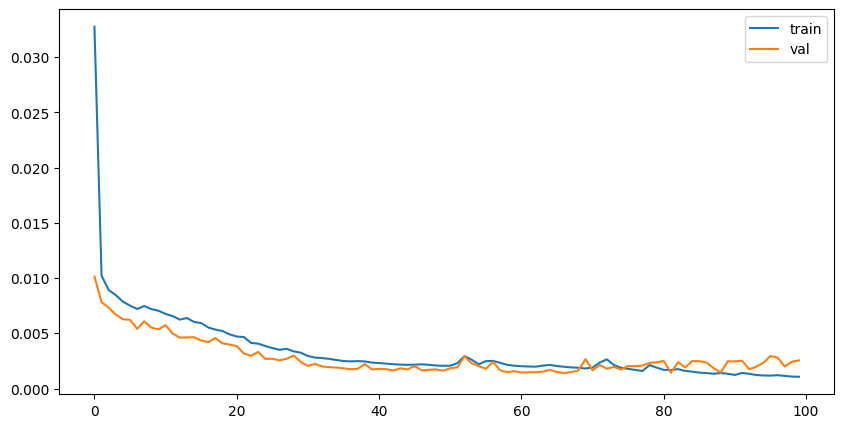

In [17]:
plt.figure( figsize=(10,5) ) 
plt.plot( history.history['loss'], label='train')
plt.plot( history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [18]:
model.save("inpainting_v2")

INFO:tensorflow:Assets written to: inpainting_v2/assets


INFO:tensorflow:Assets written to: inpainting_v2/assets


In [19]:
reconstructed_model = tf.keras.models.load_model("inpainting_v2", custom_objects = {"dice_coef": dice_coef})


In [20]:
rows = 15
sample_idx = 2

test_preds = reconstructed_model.predict( test_x )

4/4 [==============================] - 0s 37ms/step


In [23]:
# test_preds_uint8 = prep_dataset.denormalize_0_1_to_0_255_uint8(test_preds)

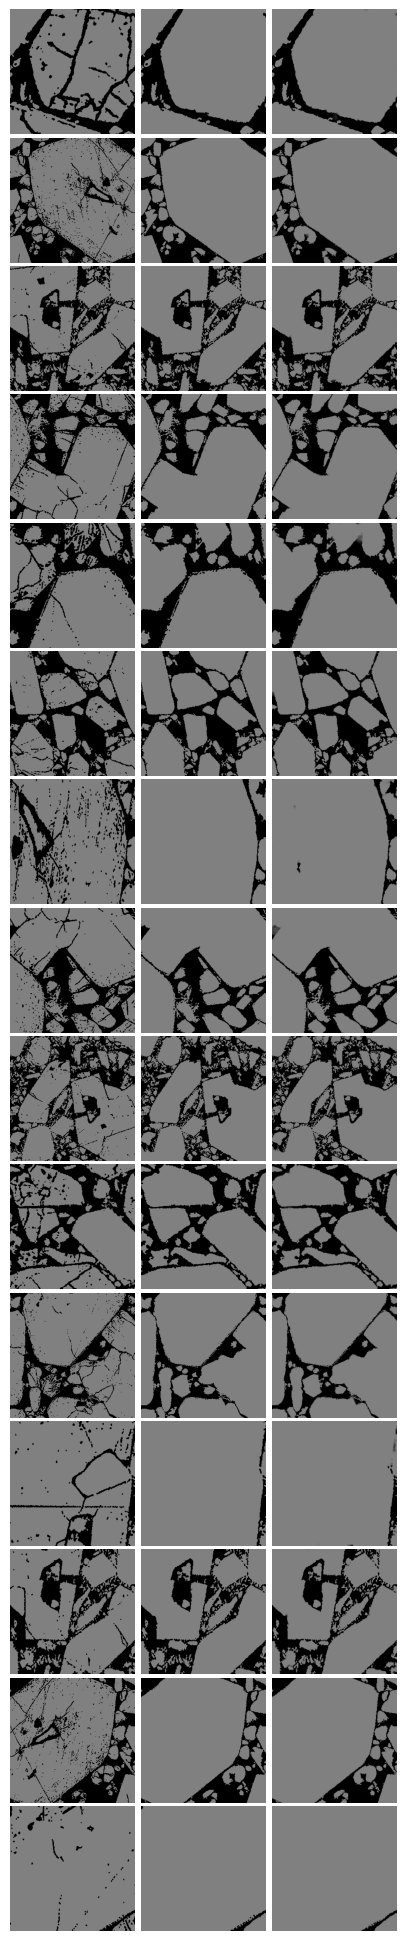

In [22]:
fig = plt.figure(figsize=(5, 2*rows))
gs = GridSpec(nrows=rows, ncols=3, figure=fig, hspace=-0.75, wspace=0.05)

for i in range(rows):
    ax1 = fig.add_subplot(gs[i, 0])
    ax2 = fig.add_subplot(gs[i, 1])
    ax3 = fig.add_subplot(gs[i, 2])
    
    ax1.imshow(test_x[i], cmap='gray', vmin=0, vmax=1)
    ax2.imshow(test_y[i], cmap='gray', vmin=0, vmax=1)
    ax3.imshow(test_preds[i], cmap='gray', vmin=0, vmax=1)
    
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()

# plt.savefig("inpainting_v2_results.png")
plt.show()